# **Please Consider Upvote if you like this Kernel.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sub=pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [3]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Analysing SalePrice

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
plt.figure(figsize=(14,8))
px.histogram(train,x='SalePrice',nbins=80,title='Selling Price Distribution')

<Figure size 1008x576 with 0 Axes>

> *Above visual shows that*
> * There is positive skewness
> * The plot is not normally distributed

# Exploring SalePrice with other Variables

> *Relationship with 'GrLivArea'*

In [6]:
plt.figure(figsize=(14,8))
px.scatter(train,x='GrLivArea',y='SalePrice',title='SalePrice vs GrLivArea',render_mode='auto',)

<Figure size 1008x576 with 0 Axes>

> Relationship with 'TotalBsmtSF'

In [7]:
plt.figure(figsize=(14,8))
px.scatter(train,x='TotalBsmtSF',y='SalePrice',title='SalePrice vs TotalBsmtSF',render_mode='auto')

<Figure size 1008x576 with 0 Axes>

> Relationship with 'OverallQual'

In [8]:
plt.figure(figsize=(14,8))
px.box(train,x='OverallQual',y='SalePrice',title='SalePrice vs OverallQual')

<Figure size 1008x576 with 0 Axes>

> Relationship with 'YearBuilt'

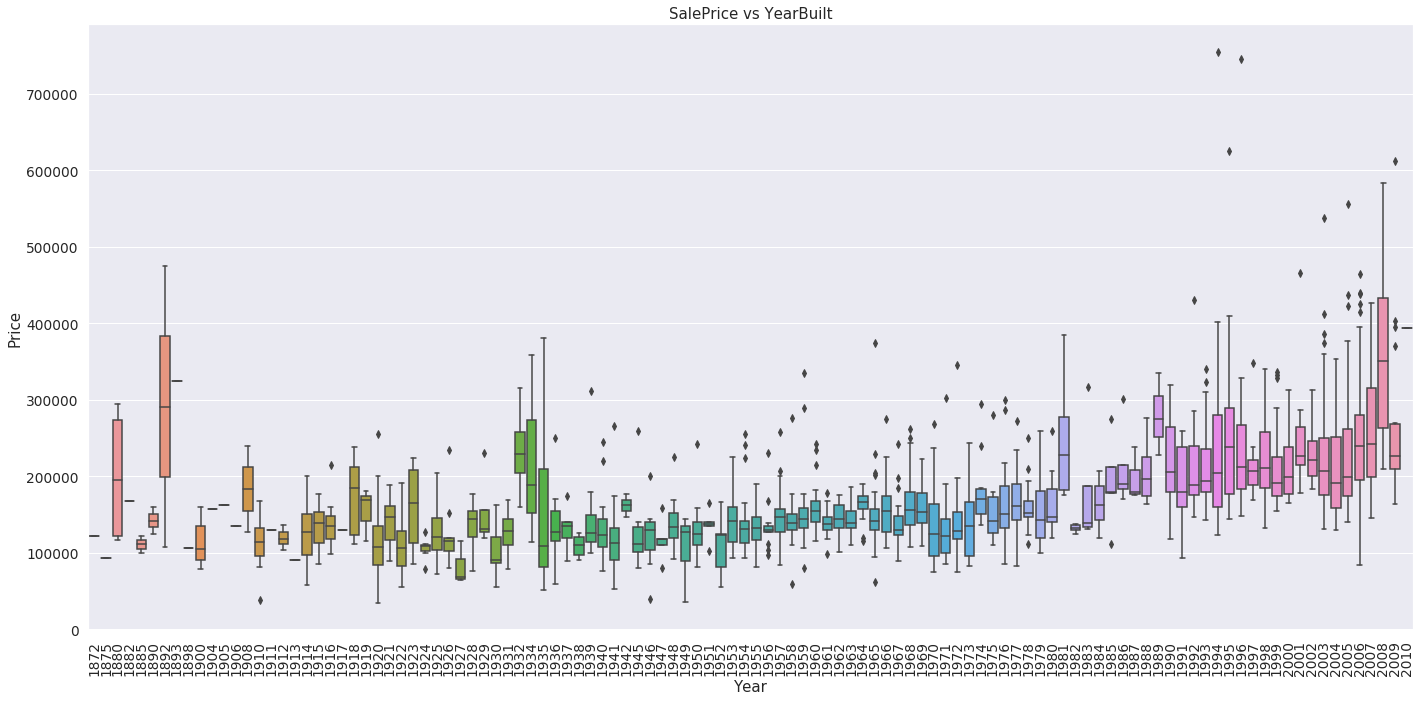

In [31]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train,x='YearBuilt',y='SalePrice')
plt.title('SalePrice vs YearBuilt')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.tight_layout()

# Finding the correlation between the different features.

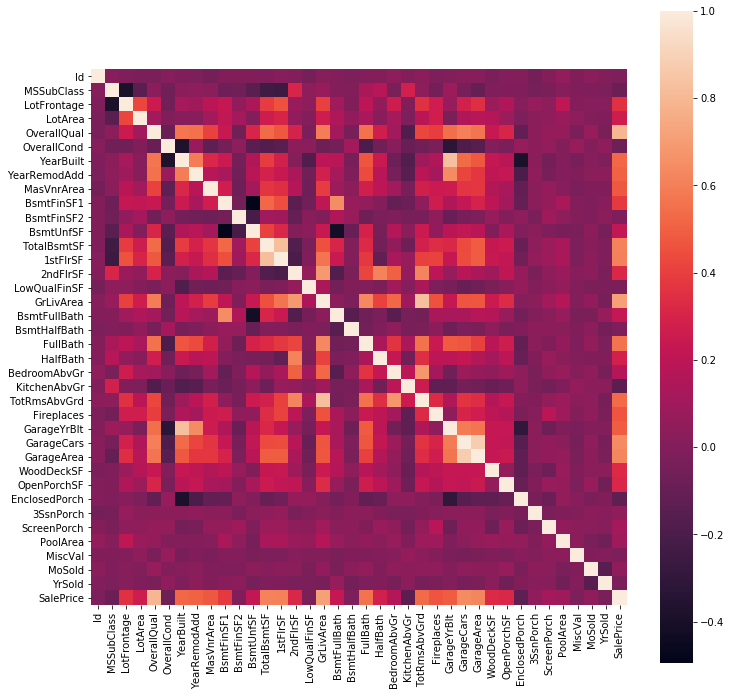

In [10]:
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(),square=True)

> SalePrice Correlation

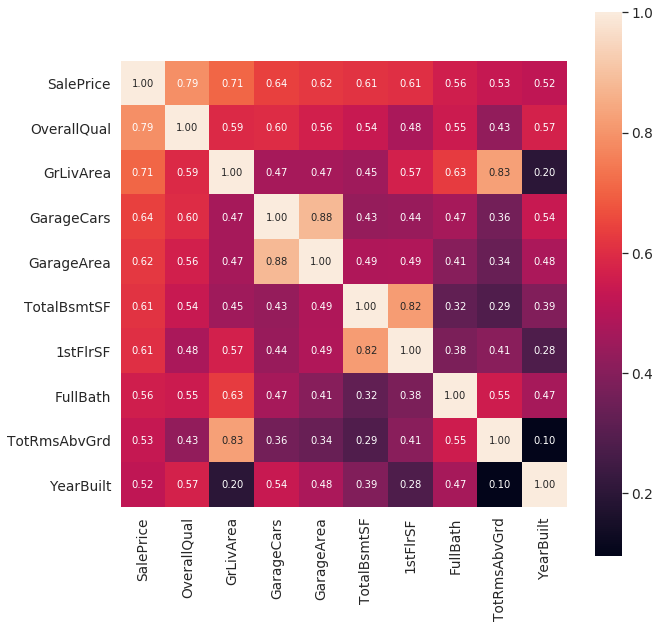

In [11]:
#saleprice correlation matrix
plt.figure(figsize=(10,10))
k = 10 #number of variables for heatmap
cols = train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

> Here there are many identical features, which means that they convey same information, so it is worthy to consider them only 1 time.
* TotalBsmtSF and 1stFlrSF are identical
* GarageCars and GarageArea are identical
* TotRmsAbvGrd and GrLivArea are identical

 

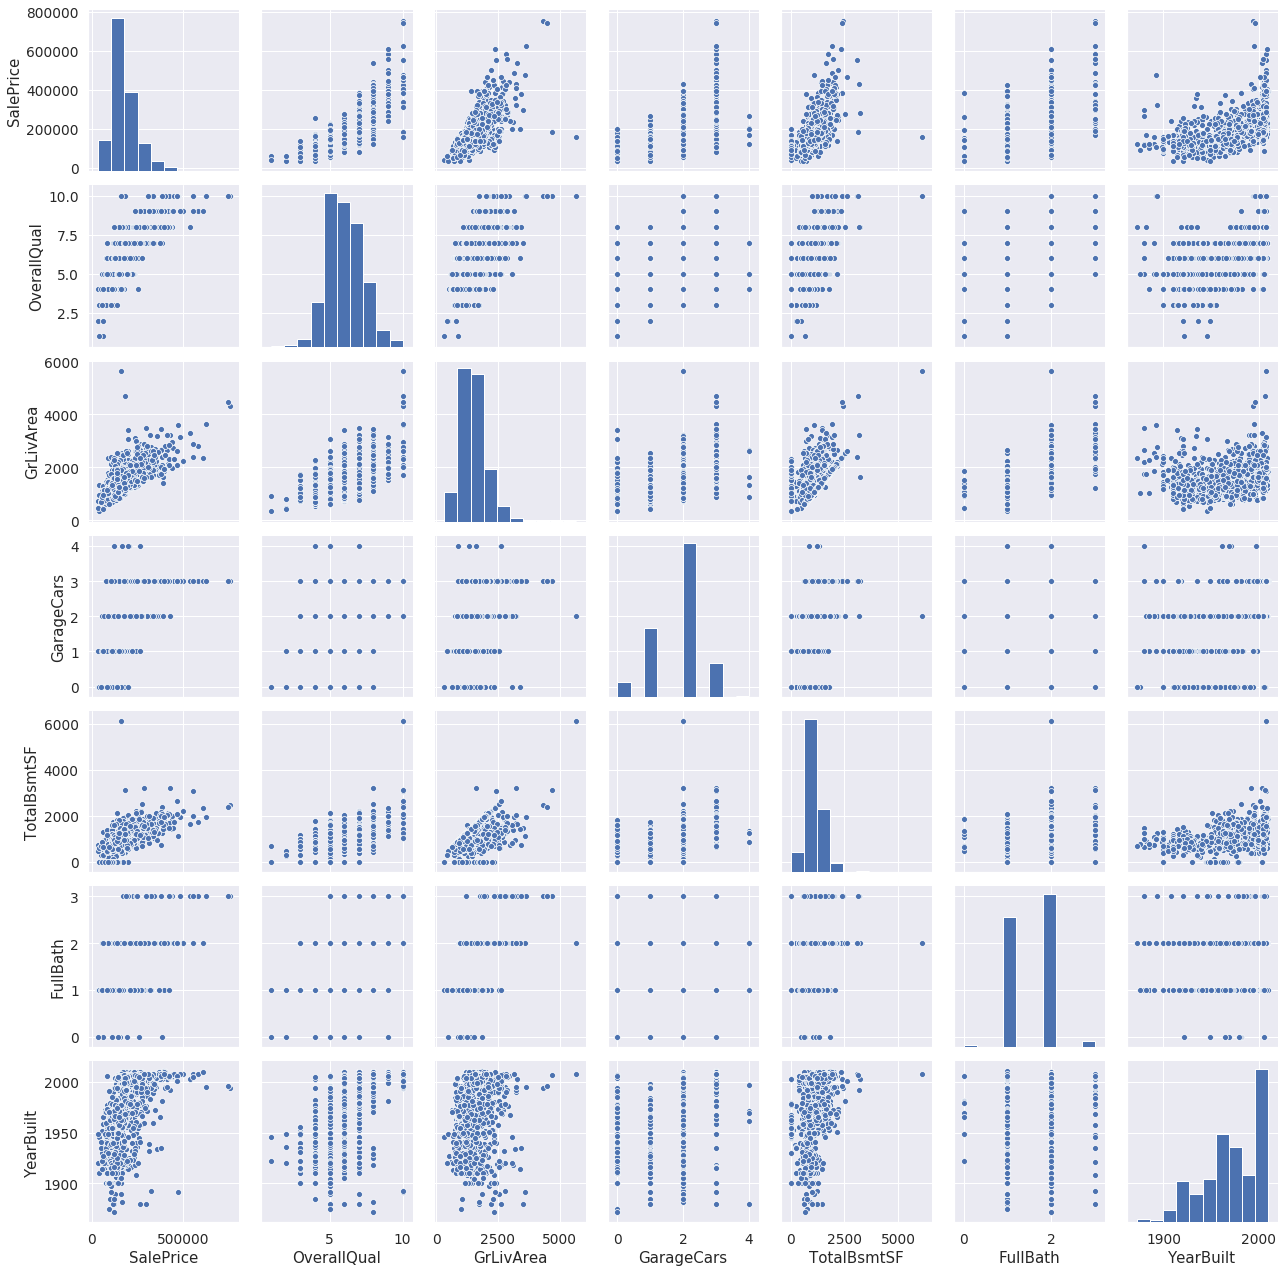

In [12]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

# Dealing with Missing Data

In [13]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (total*100) / train.shape[0]
missingData = pd.concat([total,percent],keys=['Total','Percentage'],axis=1)
missingData.head(20)

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


> We will remove the columns which will have more than 15% of missing data.

> As far as GarageX and BsmtX are concerned GarageX has the same number of missing values and they all are very identical to GarageCars. As we will consider GarageCars we can drop GarageX.

> For BsmtX, all this columns are identical to TotalBsmtSF and we can also remove all the BsmtX columns.

> MasVnrType and MasVnrArea are very closely associated with YearBuilt thus we dont need this columns as well.

> As far as one entry of Electrical is concerned we will just delete this observation and keep the variable.

In [14]:
train.drop((missingData[missingData['Total'] > 1]).index,1,inplace=True)

In [15]:
train=train.dropna()

# Removing Outliers

In [16]:
plt.figure(figsize=(14,8))
px.scatter(train,x='GrLivArea',y='SalePrice',title='SalePrice vs GrLivArea',render_mode='auto',)

<Figure size 1008x576 with 0 Axes>

> In the above scatter plot the two points where GrLivArea is very high and SalePrice is less, this two points are outliers and needed to be removed

In [17]:
train.loc[train['GrLivArea']==4676]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [18]:
train.loc[train['GrLivArea']==5642]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000


In [19]:
train = train.drop([1298,523],axis=0)

# Creating Dummy Variables.

In [20]:
test = test[train.columns[0:62]]

In [21]:
idTest = pd.DataFrame(test['Id'])

In [22]:
data = pd.concat([train, test], sort=False)
data = data.reset_index(drop=True)

In [23]:
data=pd.get_dummies(data)

In [24]:
train, test = data[:len(train)], data[len(train):]

X = train.drop(columns=['SalePrice', 'Id']) 
y = train['SalePrice']

test = test.drop(columns=['SalePrice', 'Id'])

> Spilling the training data

# Training by XGBoost algorithm with default Parameters

In [25]:
model = XGBRegressor()
model.fit(X,y)
print(r2_score(model.predict(X),y))

0.9993492488985689


> This is initial phase of the Kernel, I'll update the kernel. I'll be looking forward to following tasks:
1. Fine tuning the parameters to improve the performance.
2. Applying the model to test data and check performance.
3. Will explore the data more and see if more Data cleaning is possible or not.

# Your Upvote will be appreciated if you liked this Kernel.
## Thanks